In [3]:
# Build the C binaries
!gcc -std=c11 -O2 -march=native -fPIC -shared fft.c -o libfft.so -lm

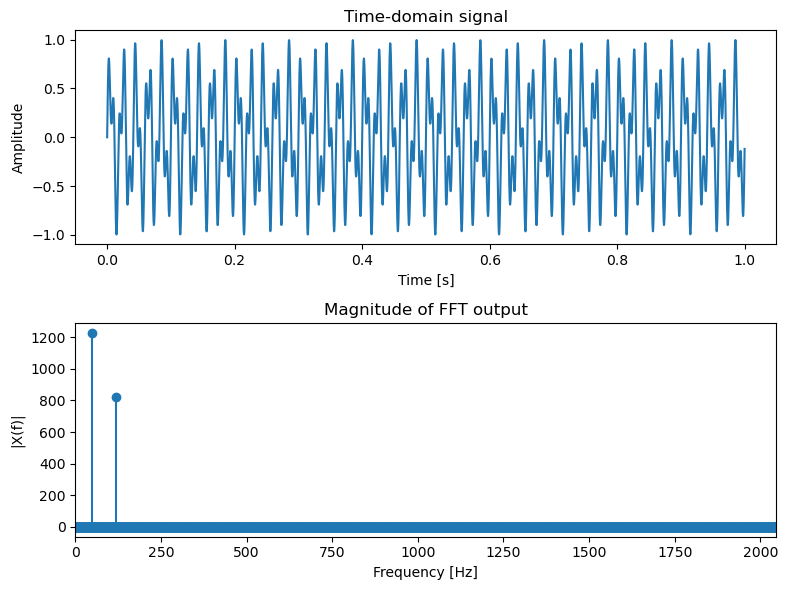

In [5]:
import numpy as np
import ctypes
from matplotlib import pyplot as plt

# ——— load the library ———
libfft = ctypes.CDLL('./libfft.so')

# Tell ctypes the signature: 
#   void fft(complex float* in, complex float* out, size_t n)
# A contiguous np.complex64 array in memory is laid out as pairs of float32,
# so we can pass its .view(np.float32) pointer to C.
libfft.fft.argtypes = (
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_size_t,
)
libfft.fft.restype = None

# ——— generate a test signal ———
n = 4096
t = np.linspace(0, 1, n, endpoint=False)
# e.g. a sum of two sinusoids
signal = 0.6*np.sin(2*np.pi*50*t) + 0.4*np.sin(2*np.pi*120*t)
signal = signal.astype(np.complex64)  # imaginary part = 0

# ——— prepare output buffer ———
out = np.zeros(n, dtype=np.complex64)

# ——— call the C FFT ———
# view as float32 so the pointer type matches ‘complex float*’
in_ptr  = signal.view(np.float32).ctypes.data_as(ctypes.POINTER(ctypes.c_float))
out_ptr =     out.view(np.float32).ctypes.data_as(ctypes.POINTER(ctypes.c_float))

libfft.fft(in_ptr, out_ptr, n)

# ——— plot time-domain and freq-domain ———
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6))

ax1.plot(t, signal.real)
ax1.set_title("Time-domain signal")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Amplitude")

freqs = np.fft.fftfreq(n, d=(t[1]-t[0]))
ax2.stem(freqs, np.abs(out), basefmt=" ")
ax2.set_xlim(0, freqs.max())
ax2.set_title("Magnitude of FFT output")
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("|X(f)|")

plt.tight_layout()
plt.show()
